# Modelos integra-y-dispara

Una parte importante del estudio y desarrollo de modelos predictivos para el potencial de membrana se concentró en lo referente a las propiedades *pasivas* de la neurona; es decir, la forma en que responde a estímulos externos sin considerar la forma en que la membrana misma se regenera. Estos modelos se basan en la ley de la capacitancia, 

$$C\dot{V}=I(t),$$

donde $I(t)$ es la función de corriente aplicada. Mientras que estos modelos tienen una solución evidente, que consiste en integrar la función $I(t)$, no son capaces de modelar por sí mismos fenómenos complejos de excitabilidad, como la generación de potenciales de acción, la repolarización de la membrana, y la existencia de períodos refractarios. Es entonces que la neurona se *resetea* manualmente tras alcanzar un valor predeterminado de umbral y se regresa al potencial de reposo. A este tipo de modelos les conocemos como **modelos integra-y-dispara (IF)**. Nosotrxs estudiaremos cuatro versiones:

- El modelo de Lapicque (1907)
- IF con fuga
- IF cuadrático
- IF exponencial

Nos servirán también para presentar algunas herramientas básicas de análisis computacional para modelos neuronales.

In [ ]:
# Cargamos la paquetería

import numpy as np
import matplotlib.pyplot as plt
from numpy.core.function_base import linspace

from scipy.integrate import solve_ivp
from scipy.integrate import odeint
from numpy import sqrt, exp, sin, cos

Para validar nuestros modelos usaremos un ruido blanco filtrado. La manera en que lo generaremos es mediante una ecuación diferencial estocástica de la forma

$$\mathrm{d}x=-x\mathrm{d}t+\sigma\mathrm{d}W_t$$,

donde $\sigma\geq0$ es un término constante de deriva, que en resumidas cuentas indica qué tan fuerte es la aleatoriedad en nuestro sistema. Nosotrxs consideraremos un valor fijo y en general no nos preocuparemos por variarlo.

In [ ]:
drift = 0.01
t = linspace(0,3000,300001)

def center(x):                                                     # Centro de la EDE
    return -x

def noise(t):                                                      # Generación del ruido
    x = np.zeros(len(t))
    dt = t[1]-t[0]
    
    for k in range(len(t)-1):
        dW = np.random.normal(loc = 0.0,scale = np.sqrt(dt))
        x[k+1] = x[k]+dt*center(x[k])+dW*drift
    
    return x

noise_st = noise(t)                                                # Éste es el vector aleatorio con el que trabajaremos

Abajo definimos una función graficadora. Esto se hace pues python no grafica automáticamente funciones que involucren valores booleanos.

In [ ]:
def graph(t,f):
    
    y = np.zeros(len(t))
    
    for k in range(len(t)):
        y[k] = f(t[k])
        
    return y

def HS(t):                                  # Función de Heaviside
    return t>=0

Echemos un vistazo rápido al término de ruido blanco que generamos. Es importante revisar la escala en que lo produjimos, pues de esto depende qué tanto aparece naturalmente en nuestros modelos.

In [ ]:
plt.plot(t,noise_st)

## El modelo de Lapicque

La primera instancia de modelos IF que revisaremos fue planteada en 1907 por Louis Lapicque y considera un reinicio manual tras integrar la función $I(t)$. El modelo queda escrito como

$$\begin{cases}
\dot{V}(t)=\dfrac{I(t)}{C}:&\, V(t)\leq V_{th},\\
V(t)\to V_{reset}:&\,V(t)>V_{th},
\end{cases} $$

donde $V_{th}$ es el umbral (correspondiente al punto más despolarizado de la membrana **antes** del disparo) y $V_{reset}$ es el potencial de reposo de la neurona. Una hipótesis natural es que $V_{reset}<V_{th}$. *Pregunta: ¿qué pasaría si $V_{th}<V_{reset}$?**

En términos matemáticos este modelo es mixto, combinando una regla de evolución dinámica con una redefinición condicional. Para resolverlo numéricamente haremos un método de Euler que permita incorporar la condición $V(t)\geq V_{th}$. También incluiremos el vector aleatorio que generamos arriba con un factor controlable de intensidad.

In [ ]:
C = 1.0                                            # Capacidad eléctrica

# t vector de tiempos
# I corriente aplicada
# Vth umbral
# Vreset reseteo
# Vspike máxima despolarización
# r intensidad del ruido

def LapIF(t,I,Vth,Vreset,Vspike,r):
    
    V = np.zeros(len(t))
    V[0] = Vreset
    dt = t[1]-t[0]
    
    for k in range(len(t)-1):
        
        Vi = V[k]
        ti = t[k]
        Vf = V[k]+dt*(I(t[k])+r*noise_st[k])/C
        
        if Vf<=Vth:
            
            V[k+1] = Vf
            
        elif Vf>Vth and Vf<Vspike:
            
            V[k+1] = Vspike
            
        else:
            
            V[k+1] = Vreset
            
    return V

En la siguiente celda podemos verificar el reseteo del potencial de membrana al alcanzar el umbral. Notemos cómo la aleatoriedad se hace presente con suficiente intensidad.

In [ ]:
def I1(t):
    return 0.1 # Corriente aplicada

Vth = -20.0
Vreset = -60.0
Vspike = 20.0
noise_int = 0.0

V = LapIF(t,I1,Vth,Vreset,Vspike,noise_int)

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo de Lapicque")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-5.0,Vspike+5.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,I1(t)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

Ahora trabajemos sin aleatoriedad, y revisemos cómo se comporta el voltaje ante la aplicación de *pulsos* de corriente.

In [ ]:
def I2(t):
    return 0.5*(t>=200)*(t<=500)+0.2*(t>=1000)           # Dos pulsos: uno de 300ms de duración y el otro de 2s

noise_int = 0.0                                          # Sin aleatoriedad

V = LapIF(t,I2,Vth,Vreset,Vspike,noise_int)

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo de Lapicque")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-5.0,Vspike+5.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,I2(t)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

Podemos automatizar la aplicación de pulsos de manera adecuada. En la siguiente celda la corriente aplicada sigue una forma tipo-seno pero por bloques. Podemos controlar la altura de estos bloques, lo que conlleva a variación en el número de potenciales de acción.

In [ ]:
def I3(t):
    
    return HS(sin(0.01*t))                  # Bloques periódicos

V = LapIF(t,I3,Vth,Vreset,Vspike,noise_int)

In [ ]:
fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo de Lapicque")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-5.0,Vspike+5.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,I3(t)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

La simulación anterior hace evidente una falla importante de los modelos IF: la **memoria infinita**. Esto quiere decir que, a falta de estimulaciones posteriores, el estado del sistema (en este caso, el voltaje) recuerda **indefinidamente** el último estímulo que recibió para todo tiempo futuro. También podemos notar que este modelo no incorpora períodos refractarios por sí mismo, sino que lo deja al tipo de corriente que se le aplique.

Por último, notemos la forma en que la frecuencia de disparo varía con la intensidad de la corriente aplicada. Esto lo podemos hacer manualmente, calculando el número de espigas que presenta a lo largo de la simulación. ¿De qué forma varía este número al incrementar $I(t)$?

In [ ]:
def I4(t):
    return 0.5*(t>=500)

V = LapIF(t,I4,Vth,Vreset,Vspike,0.0)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo de Lapicque")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-5.0,Vspike+5.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,graph(t,I4))
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

In [ ]:
plt.plot([0.1,0.2,0.3],[6,12,18])
plt.xlabel("Intensidad")
plt.ylabel("Frecuencia")

La frecuencua en el modelo de Lapicque incrementa linealmente con la intensidad de la corriente aplicada.

Con esta información podemos elaborar una gráfica de frecuencia contra intensidad, o **gráfica FI**.

## Modelo IF con fuga (leaky)

Un punto intermedio entre las propiedad pasivas de la membrana y la dinámica interior considera la integración de una *corriente de fuga*, principalmente asociada a aniones, que es una corriente óhmica de la forma

$$I_L=g_L(V-E_L).$$

Más adelante veremos que las corrientes de fuga disminuyen la excitabilidad de la neurona y la *ayudan* a alcanzar su potencial de reposo. El modelo IF que estudiaremos ahora toma la siguiente forma,

$$\begin{cases}
\dot{V}(t)=\dfrac{1}{C}\left(I(t)-g_L(V-E_L)\right):&\, V(t)\leq V_{th},\\
V(t)\to V_{reset}:&\,V(t)>V_{th},
\end{cases} $$

donde $g_L>0$ es la conductancia de la corriente de fuga, y $E_L\in\mathbb{R}$ es el potencial de reversión.

In [ ]:
C = 1.0
g = 0.1
E = -0.5

C = 1.0                                            # Capacidad eléctrica

def LeakIF(t,I,Vth,Vreset,Vspike,r):
    
    V = np.zeros(len(t))
    V[0] = Vreset
    dt = t[1]-t[0]
    
    for k in range(len(t)-1):
        
        Vf = V[k]+dt*(I(t[k])-g*(V[k]-E)+r*noise_st[k])/C
        
        if V[k]<=Vth:
            
            V[k+1] = Vf
            
        elif V[k]>Vth and V[k]<Vspike:
            
            V[k+1] = Vspike
            
        elif V[k]>= Vspike:
            
            V[k+1] = Vreset
            
    return V

Notemos que ya no hay, estrictamente hablando, un fenómeno de memoria infinita en el modelo con fuga. Podemos comparar esto con el modelo de Lapicque.

In [ ]:
Vth = 1.0
Vreset = -1.0
Vspike = 3.0
noise_int = 0.0

def I5(t):
    
    return 0.15                  # Bloques periódicos

V = LeakIF(t,I5,Vth,Vreset,Vspike,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo IF con fuga")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vspike+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,graph(t,I5)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

In [ ]:
def I2(t):
    return 0.15*(t>=200)*(t<=500)+0.15005*(t>=1000)           # Dos pulsos: uno de 300ms de duración y el otro de 2s

noise_int = 0.0

V = LeakIF(t,I2,Vth,Vreset,Vspike,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo IF con fuga")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vspike+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,graph(t,I2)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

In [ ]:
def I4(t):
    return 0.15002*(t>=2000)

noise_int = 0.0

V = LeakIF(t,I4,Vth,Vreset,Vspike,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo IF con fuga")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vspike+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,graph(t,I4)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

<blockquote>

### Tarea 1:

**Ejercicio 1.-** Grafica la solución del modelo de Lapicque para las siguientes corrientes aplicadas:

- $I(t)=k$, con $k$ constante
- $I(t)=k\sin(0.1 t)$

Elige al menos tres valores distintos para $k$ en cada caso y compara cómo cambia la evolución del potencial de membrana (debes elegir $k$ para que en efecto se aprecie un cambio). Comenta tus descubrimientos.

**Ejercicio 2.-** Grafica la solución del modelo IF con fuga para las siguientes corrientes aplicadas:

- $I(t)=k$,con $k$ constante
- $I(t)=k\sin(0.1 t)$

Elige al menos tres valores distintos para $k$ en cada caso y compara cómo cambia la evolución del potencial de membrana (debes elegir $k$ para que en efecto se aprecie un cambio). Comenta tus descubrimientos.

**Ejercicio 3.-** Grafica las curvas FI para los dos ejercicios anteriores en el caso de las corrientes constantes.

**Ejercicio 4.-** ¿Qué pasa en el modelo IF con fuga cuando $I(t)=0$ y $E>V_{th}$?

**Ejercicio 5.-** ¿Cómo implementarías, en términos de código o de matemáticas, un período refractario para cualquiera de estos modelos?
    
</blockquote>

## Modelo IF cuadrático (QIF)

El modelo cuadrático sigue el mismo esquema de reseteo de los demás modelos IF, solo que ahora la ecuación diferencial depende cuadráticamente del potencial de membrana. Las reglas de evolución toman la forma

$$\begin{cases}
\dot{V}(t)=V^2(t)+I(t)&:\, V(t)\leq V_{max},\\
V(t)\to V_{reset}&:\,V(t)>V_{max},
\end{cases} $$

lo que permite generar espigas más parecidas a las observadas en experimentos. El parámetro $V_{max}$ representa el estado más despolarizado de la neurona. A diferencia de las propuestas anteriores, el modelo QIF tiene un umbral definido que no requiere de imposiciones por parte del observador. Lo que es más, la forma concreta de la evolución subumbral garantiza que el valor máximo $V_{max}$ se alcanza siempre que $I(t)>0$ durante el suficiente tiempo. A esto le llamamos un **tiempo de escape finito**.

**Nota:** si la corriente aplicada no es constante, la expresión de la evolución subumbral puede involucrar una ecuación diferencial para la que no existen soluciones analíticas.

In [ ]:
def QIF(t,I,Vmax,Vreset,r):
    
    V = np.zeros(len(t))
    dt = t[1]-t[0]
    
    for k in range(len(t)-1):
        
        Vf = V[k]+dt*(V[k]**2+I(t[k])+r*noise_st[k])
        
        if Vf<=Vmax:
            
            V[k+1] = Vf
                        
        else:
            
            V[k+1] = Vreset
            
    return V

In [ ]:
def I2(t):
    return -1+0.99*(t>=200)*(t<=500)+1.005*(t>=1000)           # Dos pulsos: uno de 300ms de duración y el otro de 2s

Vmax = 10.0
Vreset = -1.0
noise_int = 0.0

V = QIF(t,I2,Vmax,Vreset,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo QIF")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vmax+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,graph(t,I2)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")

## Modelo IF exponencial (EIF)

El último modelo integra-y-dispara que discutiremos es el modelo exponencial (EIF). Como se aprecia abajo, el modelo incluye un término exponencial *centrado* alrededor de un valor de umbral intrínseco de la membrana $V_T$, una rapidez de activación $\Delta_T$, y una corriente de fuga como antes.

$$\begin{cases}
\dot{V}(t)=-g(V-E)+\Delta_T\exp\left(\dfrac{V-V_T}{\Delta_T}\right)+I(t)&:\, V(t)\leq V_{max},\\
V(t)\to V_{reset}&:\,V(t)>V_{max}.
\end{cases} $$

Las espigas generadas por el EIF son bastante similares a las que aparecieron en el QIF. De hecho estos modelos son cualitativamente equivalentes, tanto en la forma de sus potenciales de acción como en la dinámica subyaciente. En algunos contextos, como en el modelado de neuronas piramidales, se prefiere el modelo exponencial por su cercanía a la fisiología de las neuronas estudiadas.

**Nota:** por la misma naturaleza exponencial del modelo EIF, la evolución subumbral se da por medio de una ecuación diferencial para la que no hemos visto ningún método de resolución. 

In [ ]:
g = 1.0                                                                        # Conductancia de la corriente de fuga
E = 0.0                                                                        # Potencial de reversión de la corriente de fuga
DT = 1.0                                                                       # Rapidez de la iniciación de los PAs
VT = 1.0                                                                       # Umbral intrínseco

def EIF(t,I,Vmax,Vreset,r):
    
    V = np.zeros(len(t))
    dt = t[1]-t[0]
    
    for k in range(len(t)-1):
        
        Vf = V[k]+dt*(DT*exp((V[k]-VT)/DT)-g*(V[k]-E)+I(t[k])+r*noise_st[k])
        
        if Vf<=Vmax:
            
            V[k+1] = Vf
                        
        else:
            
            V[k+1] = Vreset
            
    return V

In [ ]:
Vmax = 10.0
Vreset = -1.0
noise_int = 0.0

def I2(t):
    return -1+0.99*(t>=200)*(t<=500)+1.005*(t>=1000)           # Dos pulsos: uno de 300ms de duración y el otro de 2s

V = EIF(t,I2,Vmax,Vreset,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo Exponencial")

axs[0].plot(t,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vmax+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t,graph(t,I2)+noise_int*noise_st)
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")


### Ejercicios

Para las siguientes simulaciones consideramos un tiempo de integración de 1000 ms y corrientes aplicadas constantes, $I(t)=k$. Además, ignoramos los efectos de ruido sobre la corriente aplicada. Los parámetros relevantes a cada modelo son los mismos que en las simulaciones vistas en clase.

<blockquote>
    
- Para el modelo LeakIF, ¿es posible elegir la corriente aplicada de manera que solo se generen 10 potenciales de acción? Considera $k\approx0.15$.
- Para el modelo QIF, ¿es posible elegir la corriente aplicada de manera que solo se generen 10 potenciales de acción? Considera $k\approx0.0$.

En caso de haber encontrado las constantes $k$ de los incisos anteriores:

- Considera cuatro valores intermedios entre la referencia ($k_0=0.15$ en el modelo LeakIF, $k_0=0.0$ en el modelo QIF) y mide la frecuencia de disparo para cada uno de estos seis valores (incluyendo la referencia y el valor que encontraste).
- Comenta: ¿cómo varía la frecuencia de cada modelo? ¿Cuál de los dos es más *sensible*?
<\blockquote>

### Ejercicio

Considera el modelo QIF a 1000 ms y con una corriente aplicada tipo *rampa* cuya gráfica tenga la siguiente forma. Al tiempo $t_0=0.0$ la corriente debe valer $I(t_0)=-1.0$, y al tiempo $t_1=1000.0$ debe alcanzar el valor $I(t_1)=1.0$. ¿Qué puedes comentar sobre la frecuencia de disparo?

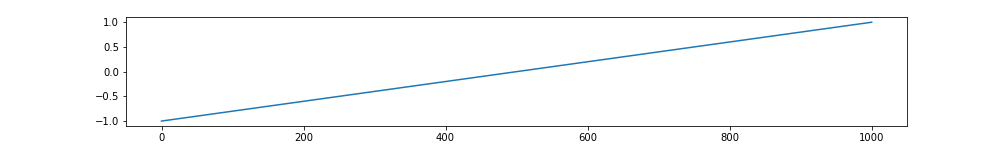

In [ ]:
t0 = linspace(0,1000,100001)

In [ ]:
def Iramp(t):
    return 1/500*t-1.0

p = plt.figure(figsize=(14,2))
p = plt.plot(t0,Iramp(t0))

plt.savefig("ramp.png")

In [ ]:
Vth = 1.0
Vreset = -1.0
Vspike = 3.0
noise_int = 0.0

# k = 0.15001
k = 0.15001

def Iexe1(t):
    return k

V = LeakIF(t0,Iexe1,Vth,Vreset,Vspike,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo IF con fuga")

axs[0].plot(t0,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vspike+1.0])
axs[0].set_ylabel("V(t)")

axs[1].plot(t0,graph(t0,Iexe1))
axs[1].set_ylabel("I(t)")
axs[1].set_xlabel("t")


In [ ]:
# k = 0.001
k = 0.0001

def Iexe2(t):
    return k          # Dos pulsos: uno de 300ms de duración y el otro de 2s

Vmax = 10.0
Vreset = -1.0
noise_int = 0.0

V = QIF(t0,Iexe2,Vmax,Vreset,noise_int)

fig, axs = plt.subplots(2,1,figsize=(13,6), gridspec_kw={'height_ratios': [2,1]})
fig.suptitle("Modelo QIF")

axs[0].plot(t0,V,color="red")
axs[0].set_ylim([Vreset-1.0,Vmax+1.0])

axs[1].plot(t0,graph(t0,Iexe2))